# Project 6d - Inferring Material Properties
As we have seen before, it's often the case that we would like to model a system without having full knowledge of the properties of that system, and that such properties will need to be inferred from data.  That is very often true of partial differential equations of many types.  

Take the following as an example: we would like to know the thermal diffusivity $k$ of some new material.  Our testing apparatus is such that we can specify the temperature at one end (a Dirichlet boundary condition of, say, $u(x=0,t) = 1$, and we can perfectly insulate the other end (the Neumann condition $\frac{\partial u}{\partial x}\left(x=1,t\right) = 0$).  We measure the temperature (with a normally-distributed error of $\sigma=0.05$) at the insulated boundary at $t=5$ and find it to be $u_{obs}(x=1,t=5) = 0.63$.  What potential thermal diffusivities are compatible with this observation?  

**Adapt the MCMC procedure that we used to calibrate SIR models to answer this question.**  Note that I have reproduced the Metropolis algorithm class and the SIR likelihood class to serve as a starting point.  Note that you will *not* need to modify the Metropolis class, but you *will* need to modify the SIR class to work with your diffusion equation solver instead, and to represent the observation scenario described above.  It is worth mentioning that you will have to run the diffusion solver to $t=5$ many times (on the order of tens of thousands of runs) with many different possible diffusivities.  As such, it will behoove you to use the largest time step (and $\Delta x$) that you can that is still accurate.  I encourage you to use backward Euler - however you should compare computed solutions at the final time for different time steps (for some assumed $k$ and outside the framework of MCMC) to see how big a time step you can use while still getting accurate results.  


In [1]:
import numpy as np
import ode_methods as om
import matplotlib.pyplot as plt

class Diffusion:
    def __init__(self, nx, dx, k=0.01):
        self.nx = nx
        self.dx = dx
        self.k = k
        self.A = self.create_matrix()
    
    def create_matrix(self):
        A = np.zeros((self.nx, self.nx))
        for i in range(1, self.nx - 1): # Interior points
            # here we use k directly, while in the explicit method we used 1, -2, 1 and then multiplied by k in the right hand side
            A[i, i - 1] = self.k
            A[i, i] = -2 * self.k
            A[i, i + 1] = self.k
        A /= self.dx**2 # Normalizing by dx^2
        return A
    
    def stiffness_matrix(self, dt):
        # Stiffness matrix for Backward Euler
        I = np.identity(self.nx)
        return I / dt - self.A
    
    def load_vector(self, u, dt):
        # Load vector for Backward Euler
        return u / dt
    
class BackwardEuler:
    def __init__(self):
        pass

    def step(self, ode, t, dt, u_0):
        # Compute the matrix L and vector f for the linear system L*u_{t+1} = f
        L = ode.stiffness_matrix(dt)
        f = ode.load_vector(u_0, dt)
        # Solve the linear system
        return np.linalg.solve(L, f)
    
def diffuImplicit(_k=0.01, _dt=0.05, _t_span=(0,50)):
    # Setup
    L = 1.0  # Length of the domain
    nx = 100  # Number of grid points
    dx = L / (nx - 1)  # Grid spacing
    x = np.linspace(0, L, nx)  # Position array
    u0 = np.zeros(nx)  # Initial condition array
    u0[0] = 1

    # Parameters
    k = _k  # Diffusion coefficient
    dt = _dt  # Time step
    t_span = _t_span  # Time span

    # Setup model and solver
    ode = Diffusion(nx, dx, k)
    method = BackwardEuler()
    integrator = om.Integrator(ode, method)
    t, u = integrator.integrate(t_span, dt, u0)

    # Visualization
    cmap = plt.cm.viridis
    for tt, uu in zip(t[::10], u[::10]): # Plot every 10th solution
        plt.plot(x, uu, color=cmap(tt/t[-1]))
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Diffusion using Backward Euler")
    plt.show()

In [3]:
import numpy as np
import ode_methods as om

class Metropolis:
    def __init__(self):
        # Initialize chains 
        self.P_chain = []
        self.m_chain = []
        
    def sample(self,m_0,log_posterior,h,n_samples,burnin=0,thin_factor=1):
        # Compute initial unscaled log-posterior
        P_0 = log_posterior(m_0)
        
        # Add initial location and posterior to the chain
        self.P_chain.append(P_0)
        self.m_chain.append(m_0)
        n = len(m_0)

        # Draw samples
        for i in range(n_samples):


            # Propose new value
            m_prime = m_0 + np.random.randn(n)*h

            # Compute new unscaled log-posterior
            P_1 = log_posterior(m_prime)
            
            # Compute logarithm of probability ratio
            log_ratio = P_1 - P_0
            
            # Convert to non-log space
            ratio = np.exp(log_ratio)
            
            # If proposed value is more probable than current value, accept.  
            # If not, then accept proportional to the probability ratios
            if ratio>np.random.rand():
                m_0 = m_prime
                P_0 = P_1
                
            # Only append to the chain if we're past burn-in. 
            if i>burnin:
                # Only append every j-th sample to the chain
                if i%thin_factor==0:
                    self.P_chain.append(P_0)
                    self.m_chain.append(m_0)
            
            if i%100==0:
                print(i, P_1)
                    
        return np.array(self.P_chain),np.array(self.m_chain)

# Instantiate sampler
sampler = Metropolis()
    
class DiffusionPosterior:
    def __init__(self,t_obs,u_obs,sigma2_obs):
        self.u_obs = u_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,log_m):
        # We have defined our parameters to sample over as the logarithm
        # of the model parameters.  Here we exponentiate them to get
        # the representation that we need.  
        m = np.exp(log_m)
        k = m[0] 
        dt = m[1]
        nx = 100
        dx = 1/(nx-1)
        t_span = (0,10)
        
        u0 = np.zeros(nx)
        u0[0] = 1

        ode = Diffusion(nx, dx, k)
        method = BackwardEuler()
        integrator = om.Integrator(ode, method)
        t, u = integrator.integrate(t_span, dt, u0)
        P = -0.5*np.sum((self.u_obs - u)**2)/self.sigma2_obs
        return P

**Find a way to visualize the distribution of $k$ values.  Verify that these are sensible solutions by running the model forward with these values and ensuring that they match the observations consistent with the stated errors.**  

0 -972656.4549647217


/tmp/ipykernel_118470/3129136841.py:33: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_ratio)


100 -623222.6113285099
200 -432423.60488954035
300 -269225.5390502752
400 -172604.6896989508
500 -112803.22638338052
600 -89941.74699015007
700 -65188.953644661444
800 -45729.10964184906
900 -33269.085227682815
1000 -27003.363651579184
1100 -21392.334364543392
1200 -16709.51417022248
1300 -14295.442549965268
1400 -14173.74246485188
1500 -12061.733419499145
1600 -12041.763219522105
1700 -12021.219119696681
1800 -12010.329266776069
1900 -12003.203915789438
2000 -11995.14483553057
2100 -11989.720713808103
2200 -11985.353490101714
2300 -11984.512583385917
2400 -11979.721611607425
2500 -11977.513466134438
2600 -11974.58509410448
2700 -11976.053190332621
2800 -11976.78204522426
2900 -11977.16766800846
3000 -11977.198119452616
3100 -11974.192581618569
3200 -11971.757638891326
3300 -11971.381932502618
3400 -11972.67005862056
3500 -11970.859800602335
3600 -11968.873449858507
3700 -9928.892634706057
3800 -9929.470155986543
3900 -9929.54609299493
4000 -9930.150472063922
4100 -9930.060485535178
42

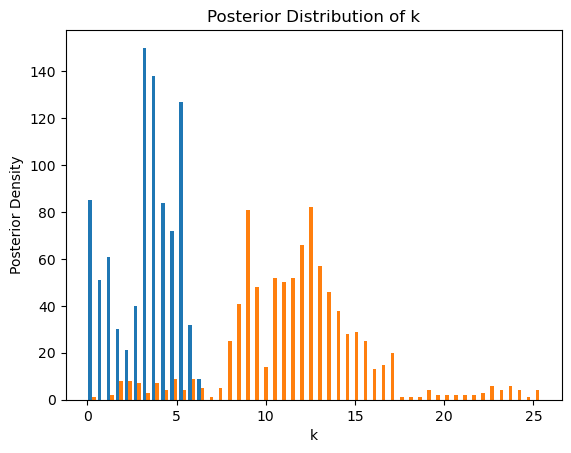

In [4]:
temp_obs = 0.63 # u(x=1,t=5)
t_obs = 5 # t=5
sigma2_obs = 0.05**2 # sigma=0.05
diffusion_posterior = DiffusionPosterior(t_obs,temp_obs,sigma2_obs) # Instantiate the posterior
log_m = np.log(np.array([0.01,0.05])) # Initial guess for k and dt
P_chain,m_chain = sampler.sample(log_m,diffusion_posterior.log_posterior,0.01,10000,burnin=1000,thin_factor=10) # Sample the posterior
plt.hist(m_chain,bins=50) # Plot the posteriors for k
plt.xlabel("k")
plt.ylabel("Posterior Density")
plt.title("Posterior Distribution of k")
plt.show()